# Autoregressive Models

On this Notebook, some Autoregressive Models are tried in the job to solve the competition problem. The idea here is to find the most suitable model to use on an Ensemble with other constructed model.

## Libraries

In [1]:
import numpy as np 
import pandas as pd 
from cnr_methods import get_simplified_data
import matplotlib.pyplot as plt


from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


## Data Extraction

In [2]:
full_data, full_label = get_simplified_data()

To simplify the analysis, let's work only with Training Data of Wind Farm 1.

In [3]:
X = full_data[full_data['Set']=='Train']
X = X[X['WF']=='WF1']
y = full_label[full_label.index.isin(X['ID'])]

## Facebook Prophet

The First method that will be tried is the Facebooks's Prophet. First thing to do is convert the data to the Standard Format required by Prophet.

In [4]:
y = y.reset_index()
y = y.merge(X.reset_index()[['Time','ID']],on='ID',how='left')
y = y[['Time','Production']]
y.columns = ['ds','y']

In [5]:
y.head()

,ds,y
0,2018-05-01 01:00:00,0.02
1,2018-05-01 02:00:00,0.07
2,2018-05-01 03:00:00,0.22
3,2018-05-01 04:00:00,0.39
4,2018-05-01 05:00:00,0.41


Let's divide the Data on Train and Hold Set. As the data has nearly 8 months of data, we'll separate the last month as the Holdout Set.

In [6]:
split = round(7*len(y)/8)

y_train = y[:split]
y_hold = y[split:]

Now, let's apply the Model.

In [7]:
m = Prophet(growth='linear',n_changepoints=100,changepoint_prior_scale = 5,yearly_seasonality=False,weekly_seasonality=False)

In [8]:
m.fit(y_train)

In [9]:
future = m.make_future_dataframe(periods=780,freq='H',include_history=False)

In [10]:
forecast = m.predict(future)

In [11]:
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

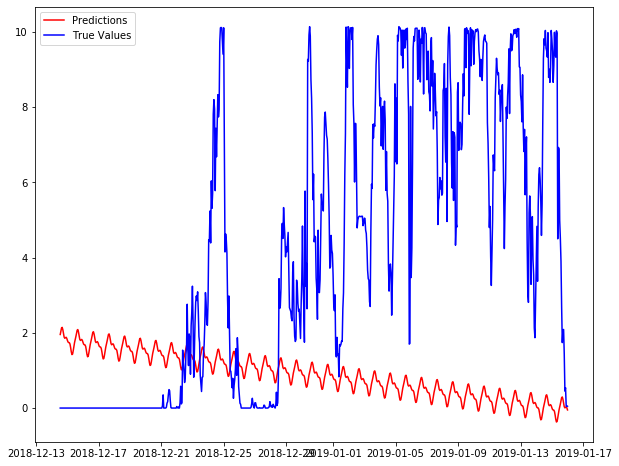

In [12]:
plt.figure(figsize=(10,8))
plt.plot(forecast['ds'],forecast['yhat'],'r',label='Predictions')
plt.plot(forecast['ds'],y_hold['y'],'b',label='True Values')
plt.legend()